<a href="https://colab.research.google.com/github/gigihsantoso/Linear-Regression-Health-Costs-Calculator/blob/main/fcc_predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [267]:
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv

--2022-09-02 03:53:19--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 104.26.2.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 50264 (49K) [text/csv]
Saving to: ‘insurance.csv.15’

insurance.csv.15    100%[===================>]  49.09K  --.-KB/s    in 0.001s  

2022-09-02 03:53:19 (42.7 MB/s) - ‘insurance.csv.15’ saved [50264/50264]



In [268]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [269]:
dataset = pd.read_csv('insurance.csv')
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [270]:
def dataframe_split(data, ratio= 0.2, shuffle= 0):
  len_ = int(len(data) - (ratio*len(data)))
  if shuffle == 0 :
    part_  = data.iloc[:int(1 + len_)]
    rest_part_ = data.drop(part_.index)
  elif shuffle == 1:
    part_ = data.sample(frac = 1.0 - ratio)
    rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

In [271]:
def dataframe_to_dataset(data, batch_size=4):
  df = data.copy()
  labels = df.pop('expenses')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [272]:
def numeric_preprocessing(name, dataset):
  feature_dataset = dataset.map(lambda x,y: x[name])
  layer = tf.keras.layers.Normalization()
  layer.adapt(feature_dataset)

  return layer

In [273]:
def categories_preprocessing(name, dataset, dtype, output_mode="multi_hot"):
  if(dtype == "int64"):
    lookup = tf.keras.layers.IntegerLookup()
  else:
    lookup = tf.keras.layers.StringLookup()
  feature_dataset = dataset.map(lambda x,y: x[name])
  lookup.adapt(feature_dataset)

  category_encoding = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size(), output_mode=output_mode)
  return lambda feature:  category_encoding(lookup(feature))

In [274]:
def plot_metric(x, y, history, metric):
  fig, ax = plt.subplots(x, y, figsize=(15,10))
  epochs = range(len(history.history[metric[0]]))
  for metric, ax in zip(metric, ax.flatten()):
    ax.plot(epochs, history.history[metric], 'r', label='train')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    ax.legend()  
  plt.show()

In [275]:
num_keys = ["age", "bmi",	"children"]
categorical_string_keys = ["sex",	"smoker",	"region"]
all_inputs = []
all_preprocessors = []
batch_size = 4

In [276]:
train, test = dataframe_split(dataset, ratio = 0.2, shuffle=1)

In [277]:
train_dataset = dataframe_to_dataset(train, batch_size=batch_size)
test_ds = dataframe_to_dataset(test, batch_size=batch_size)

In [278]:
for num_cat in num_keys:
  input = tf.keras.Input(shape=(1,), name=num_cat, dtype="int64")
  num_layer = numeric_preprocessing(name=num_cat, dataset=train_dataset)
  num_preprocessor = num_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(num_preprocessor)

In [279]:
for categorical in categorical_string_keys:
  input = tf.keras.Input(shape=(1,), name=categorical, dtype="string")
  cat_layer = categories_preprocessing(name=categorical, dataset=train_dataset, dtype="string", output_mode="one_hot")
  cat_preprocessor = cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_preprocessor)

In [280]:
all_inputs, all_preprocessors

([<KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'bmi')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'children')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'sex')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'smoker')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'region')>],
 [<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_35')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_36')>,
  <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'normalization_37')>,
  <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_34')>,
  <KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_35')>,
  <KerasTensor: shape=(None, 5) dtype=float32 (created by layer 'category_encoding_36')>])

In [281]:
all_features = tf.keras.layers.concatenate(all_preprocessors)
x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001))(all_features)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.0001))(x)
x = tf.keras.layers.Dropout(0.2)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.linear)(x)

model = tf.keras.Model(all_inputs, output)

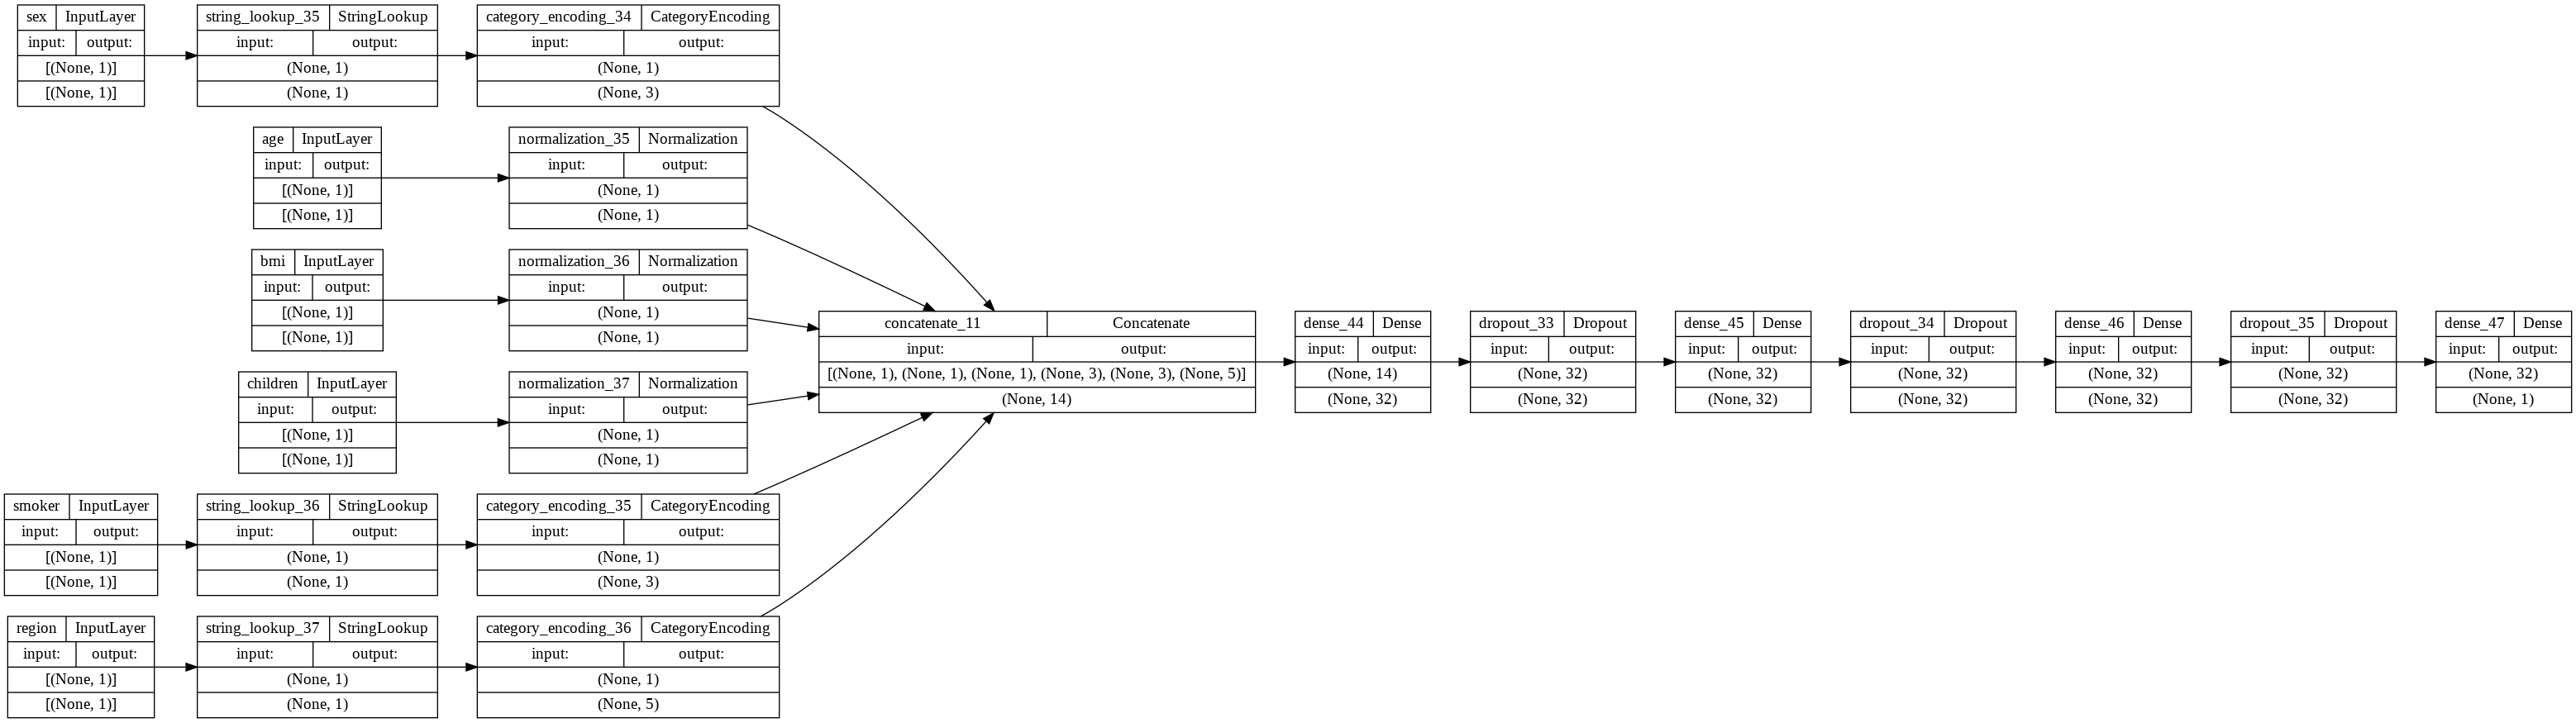

In [282]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [283]:
METRICS = [
      tf.keras.metrics.MeanAbsoluteError(name='mean_absolute_error'),
      tf.keras.metrics.MeanSquaredError(name='mean_squared_error'),
]
model.compile(loss='mean_absolute_error',
              optimizer=tf.keras.optimizers.Adam(0.001),
              metrics=METRICS)

In [284]:
history = model.fit(train_dataset, epochs=100)

Epoch 1/100
268/268 [==============================] - 1s 1ms/step - loss: 12738.5176 - mean_absolute_error: 12738.5039 - mean_squared_error: 308554912.0000
Epoch 2/100
268/268 [==============================] - 0s 1ms/step - loss: 8794.0576 - mean_absolute_error: 8794.0107 - mean_squared_error: 195231872.0000
Epoch 3/100
268/268 [==============================] - 0s 1ms/step - loss: 7350.8604 - mean_absolute_error: 7350.7959 - mean_squared_error: 148593136.0000
Epoch 4/100
268/268 [==============================] - 0s 1ms/step - loss: 6581.0957 - mean_absolute_error: 6581.0308 - mean_squared_error: 131189352.0000
Epoch 5/100
268/268 [==============================] - 0s 1ms/step - loss: 5852.4604 - mean_absolute_error: 5852.3882 - mean_squared_error: 114799960.0000
Epoch 6/100
268/268 [==============================] - 0s 1ms/step - loss: 5154.3560 - mean_absolute_error: 5154.2720 - mean_squared_error: 88843504.0000
Epoch 7/100
268/268 [==============================] - 0s 1ms/step - 

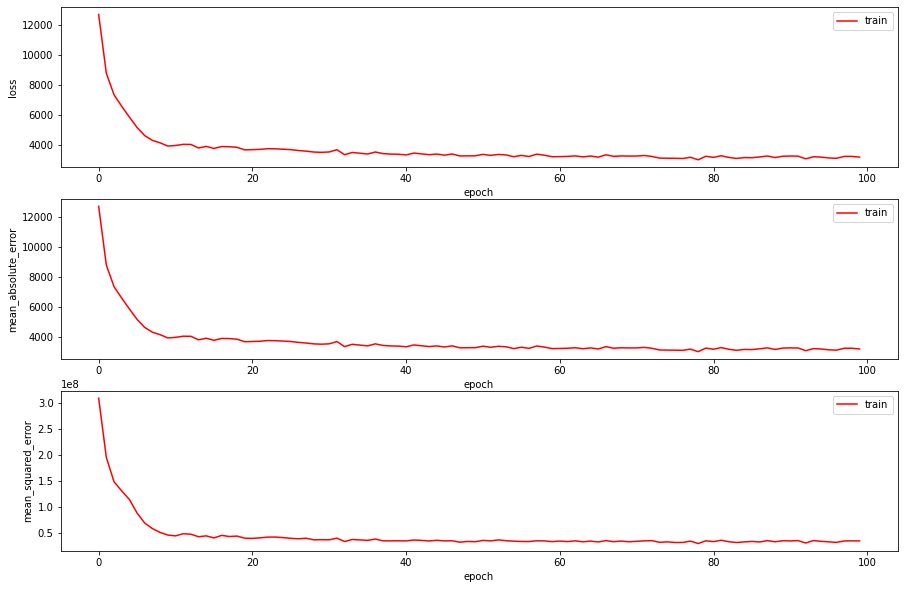

In [285]:
metric = ['loss', 'mean_absolute_error', 'mean_squared_error']
plot_metric(3,1, history, metric)

In [289]:
test_ds_unbach = test_ds.unbatch()
test_dataset = [i[0] for i in list(test_ds_unbach.as_numpy_iterator())] 
test_labels = [i[1] for i in list(test_ds_unbach.as_numpy_iterator())]

67/67 - 0s - loss: 2056.2405 - mean_absolute_error: 2056.0591 - mean_squared_error: 23975444.0000 - 269ms/epoch - 4ms/step
Testing set Mean Abs Error: 2056.06 expenses
You passed the challenge. Great job!


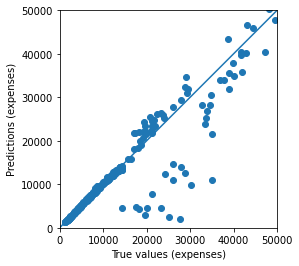

In [290]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.
loss, mae, mse = model.evaluate(test_ds, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = model.predict(test_ds).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
